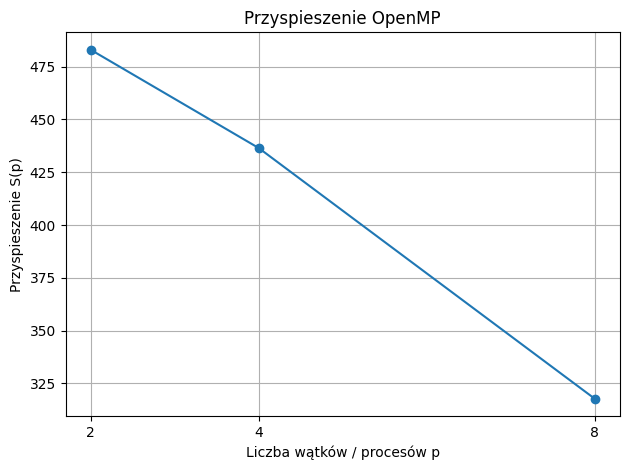

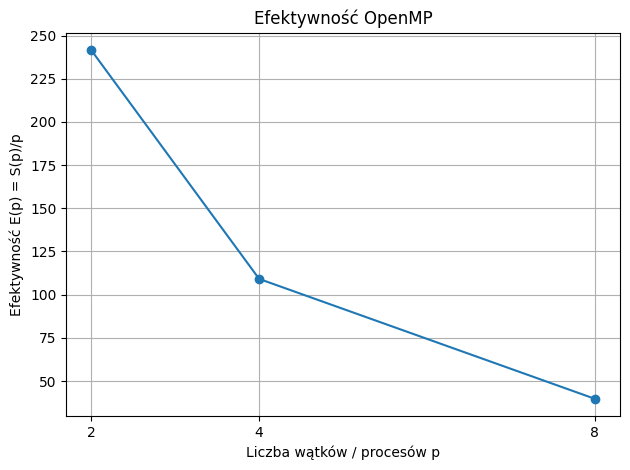

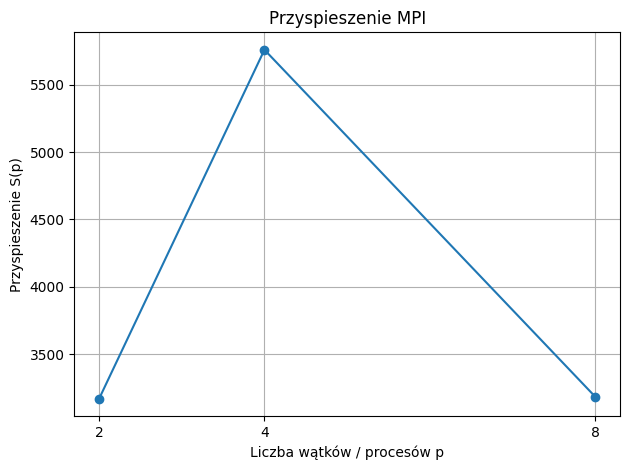

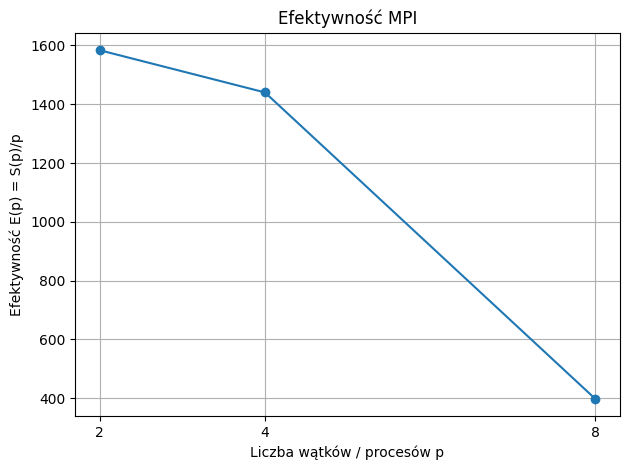

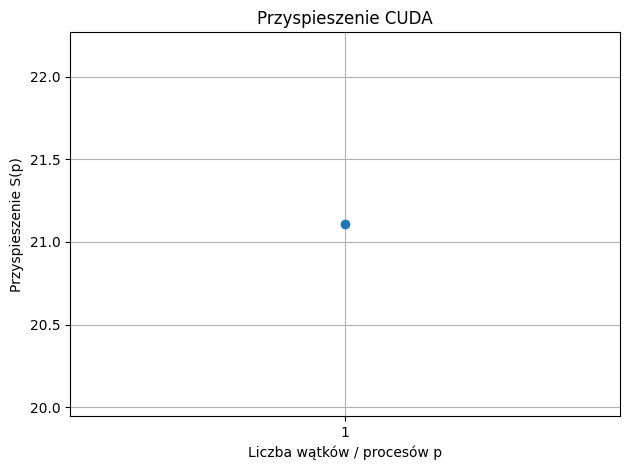

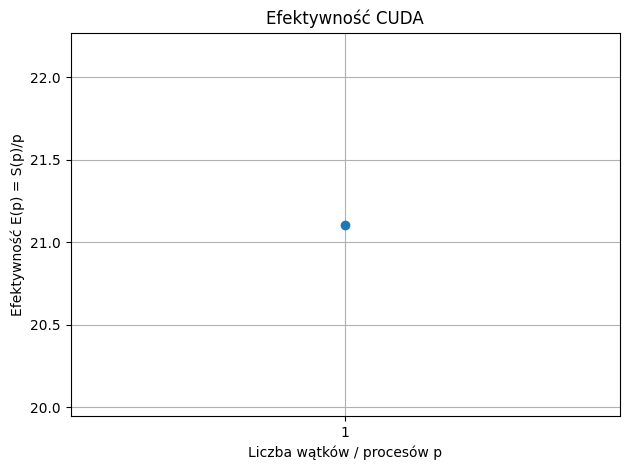

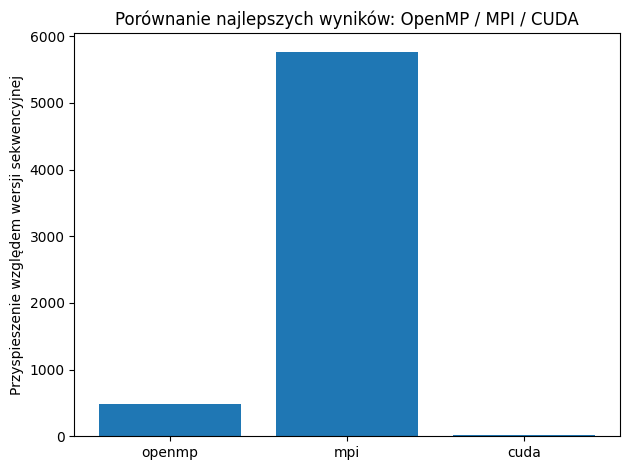

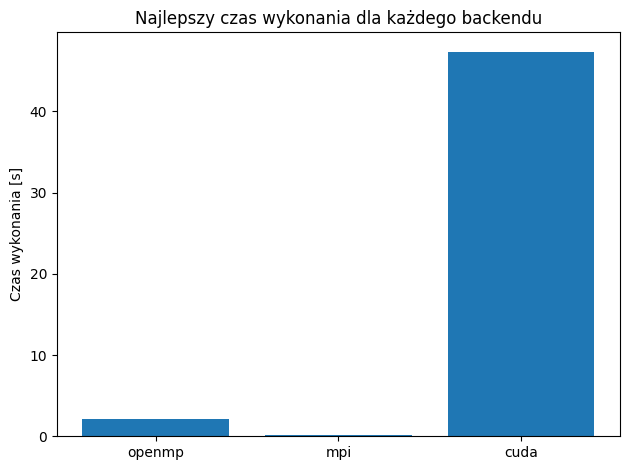

In [ ]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt

# ===== 1. Konfiguracja ścieżek i plików =====

RESULTS_DIR = Path(".")  # jeśli JSON-y są w innym katalogu, podmień tutaj

# Lista plików z wynikami (dopasowana do tego, co mi wysłałeś)
JSON_FILES = [
    "openmp_2_threads.json",
    "openmp_4_threads.json",
    "openmp_8_threads.json",
    "mpi_2_processes.json",
    "mpi_4_prpcesses.json",
    "mpi_8_processes.json",
    "cuda_20251208_190729.json",
    "cuda_20251208_192020.json",
    "cuda_default_test_run.json",
]

# >>> WSTAW TU CZAS WYKONANIA WERSJI SEKWENCYJNEJ (w sekundach) <<<
T_SEQ = 999.999  # <-- PODMIEŃ NA SWÓJ zmierzony wall_time_seconds dla backendu sekwencyjnego


# ===== 2. Wczytanie danych z JSON-ów =====

runs = []  # lista słowników: {backend, p, wall, file}

for fname in JSON_FILES:
    path = RESULTS_DIR / fname
    with open(path, "r") as f:
        obj = json.load(f)

    backend = obj["backend"]
    wall = obj["wall_time_seconds"]

    # Ustalenie "p" (liczba wątków/procesów) zależnie od backendu
    if backend == "openmp":
        p = obj["config"].get("num_threads", 1)

    elif backend == "mpi":
        # W JSON-ie num_processes jest 1, więc parsujemy z nazwy pliku: mpi_<N>_...
        m = re.search(r"mpi_(\d+)_", fname)
        if m:
            p = int(m.group(1))
        else:
            p = obj["config"].get("num_processes", 1)

    elif backend == "cuda":
        # Masz kilka pomiarów CUDA – wszystkie na jednym GPU.
        # Traktujemy to jako p = 1 (jedno urządzenie).
        p = 1

    else:
        p = 1

    runs.append({
        "backend": backend,
        "p": p,
        "wall": wall,
        "file": fname,
    })

# ===== 3. Posortowanie i zorganizowanie danych =====

# runs_by_backend: backend -> lista (p, wall, file) posortowana po p
runs_by_backend = {}
for r in runs:
    b = r["backend"]
    runs_by_backend.setdefault(b, []).append((r["p"], r["wall"], r["file"]))

for b in runs_by_backend:
    # sortujemy po p, a jeśli jest kilka wyników dla tego samego p – zachowujemy najlepszy (najmniejszy czas)
    tmp = {}
    for p, wall, fname in runs_by_backend[b]:
        if p not in tmp or wall < tmp[p][0]:
            tmp[p] = (wall, fname)
    # z powrotem do listy posortowanej po p
    runs_by_backend[b] = sorted(
        [(p, w, fname) for p, (w, fname) in tmp.items()],
        key=lambda x: x[0]
    )

# ===== 4. Funkcja pomocnicza do rysowania S(p) i E(p) =====

def plot_speedup_and_efficiency(backend_name, data):
    """
    backend_name: 'OpenMP' / 'MPI' / 'CUDA'
    data: lista (p, wall, fname)
    """
    ps = [p for p, _, _ in data]
    times = [wall for _, wall, _ in data]

    speedup = [T_SEQ / t for t in times]
    efficiency = [s / p for s, p in zip(speedup, ps)]

    # --- Przyspieszenie ---
    plt.figure()
    plt.plot(ps, speedup, marker="o")
    plt.xlabel("Liczba wątków / procesów p")
    plt.ylabel("Przyspieszenie S(p)")
    plt.title(f"Przyspieszenie {backend_name}")
    plt.grid(True)
    plt.xticks(ps)
    plt.tight_layout()
    # plt.savefig(f"speedup_{backend_name.lower()}.png", dpi=150)

    # --- Efektywność ---
    plt.figure()
    plt.plot(ps, efficiency, marker="o")
    plt.xlabel("Liczba wątków / procesów p")
    plt.ylabel("Efektywność E(p) = S(p)/p")
    plt.title(f"Efektywność {backend_name}")
    plt.grid(True)
    plt.xticks(ps)
    plt.tight_layout()
    # plt.savefig(f"efficiency_{backend_name.lower()}.png", dpi=150)


# ===== 5. Wykresy dla OpenMP i MPI =====

if "openmp" in runs_by_backend:
    plot_speedup_and_efficiency("OpenMP", runs_by_backend["openmp"])

if "mpi" in runs_by_backend:
    plot_speedup_and_efficiency("MPI", runs_by_backend["mpi"])

# Dla CUDA masz de facto jeden punkt (jeden GPU),
# ale możemy policzyć i narysować go tak samo (p=1).
if "cuda" in runs_by_backend:
    plot_speedup_and_efficiency("CUDA", runs_by_backend["cuda"])

# ===== 6. Porównanie najlepszych wyników (OpenMP / MPI / CUDA) =====

best_speedup = {}
best_times = {}

for backend, lst in runs_by_backend.items():
    # bierzemy minimalny czas dla danego backendu (najlepsza konfiguracja)
    best_p, best_wall, best_file = min(lst, key=lambda x: x[1])
    best_times[backend] = best_wall
    best_speedup[backend] = T_SEQ / best_wall

# --- wykres słupkowy speedupu ---
plt.figure()
labels = list(best_speedup.keys())
values = [best_speedup[b] for b in labels]

plt.bar(labels, values)
plt.ylabel("Przyspieszenie względem wersji sekwencyjnej")
plt.title("Porównanie najlepszych wyników: OpenMP / MPI / CUDA")
plt.tight_layout()
# plt.savefig("best_speedup_comparison.png", dpi=150)

# --- (opcjonalnie) wykres słupkowy czasów wykonania ---
plt.figure()
time_values = [best_times[b] for b in labels]
plt.bar(labels, time_values)
plt.ylabel("Czas wykonania [s]")
plt.title("Najlepszy czas wykonania dla każdego backendu")
plt.tight_layout()
# plt.savefig("best_time_comparison.png", dpi=150)

plt.show()


Czas wersji sekwencyjnej T1: 58.35301788799984 s


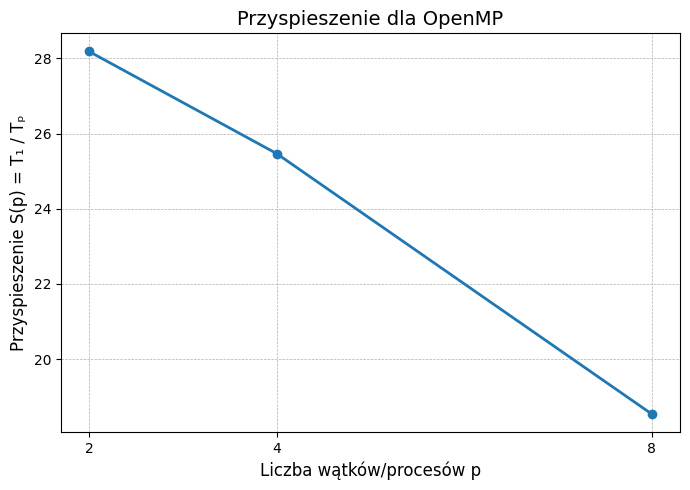

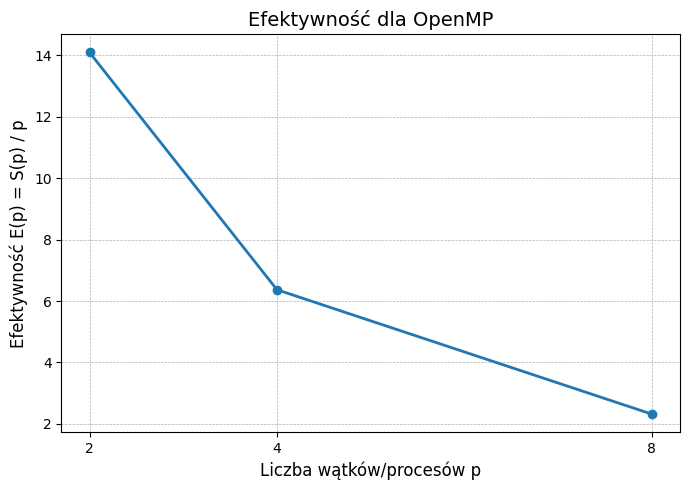

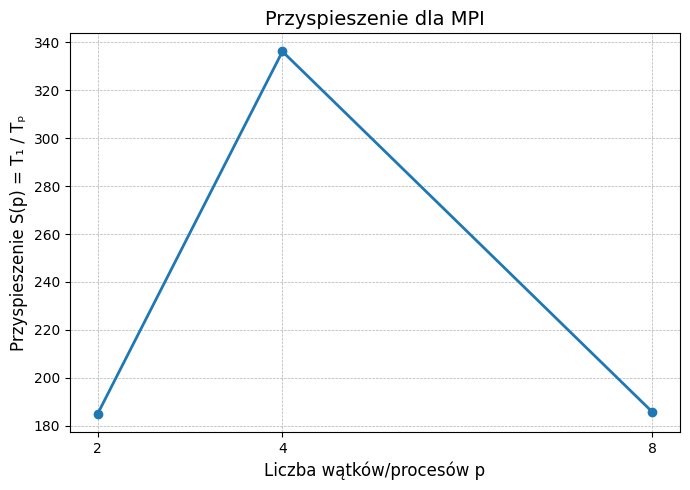

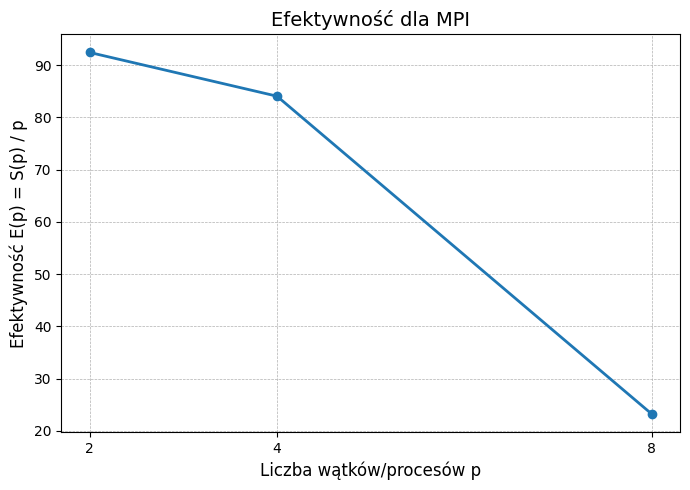

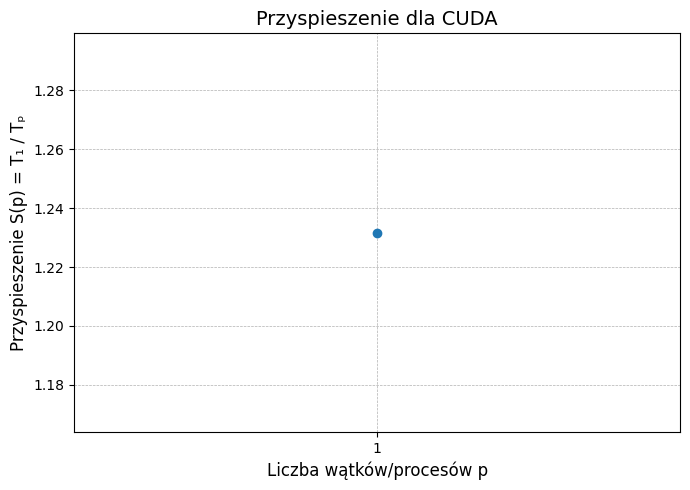

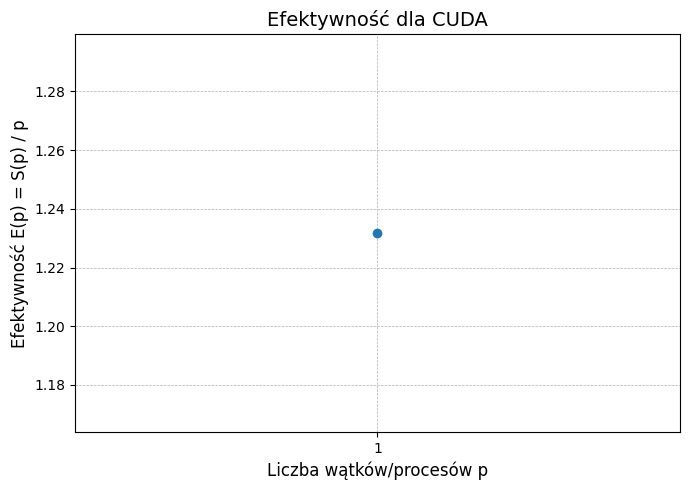

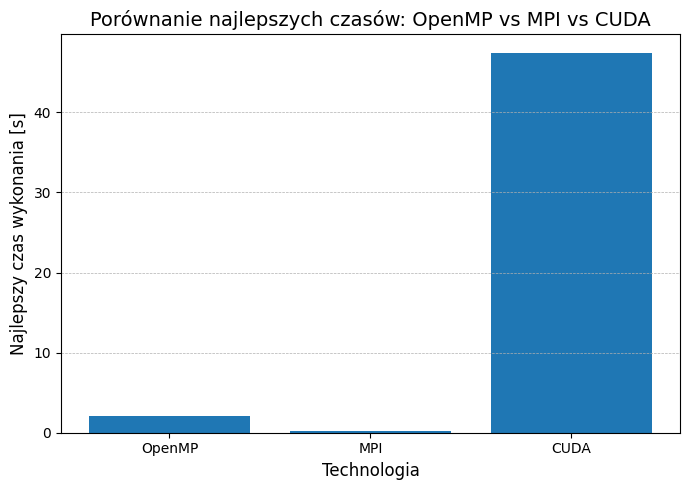

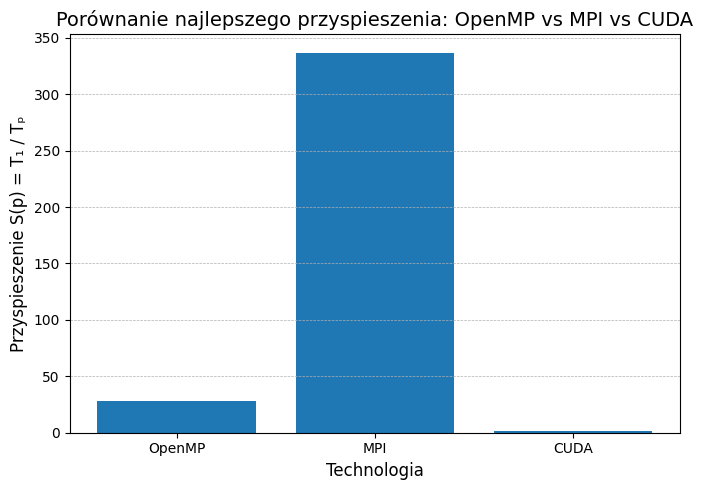

In [2]:
import json
import matplotlib.pyplot as plt

# ===== 1. Funkcje pomocnicze =====

def load_run(path):
    """Wczytaj pojedynczy plik JSON z wynikami."""
    with open(path, "r") as f:
        return json.load(f)

def prepare_backend_data(file_dict):
    """
    Zamienia słownik {p: filename} na listę:
    [(p, wall_time_seconds, filename), ...] posortowaną po p.
    """
    data = []
    for p, fname in sorted(file_dict.items(), key=lambda x: x[0]):
        run = load_run(fname)
        wall_time = run["wall_time_seconds"]
        data.append((p, wall_time, fname))
    return data

def plot_speedup_and_efficiency(backend_name, data, T_seq):
    """
    Rysuje dwa wykresy dla danego backendu:
    - przyspieszenie S(p) = T_seq / T_p
    - efektywność E(p) = S(p) / p
    gdzie:
      backend_name: 'OpenMP', 'MPI', 'CUDA'
      data: lista (p, wall_time, filename)
      T_seq: czas wykonania wersji sekwencyjnej
    """
    ps = [p for p, _, _ in data]
    times = [wall for _, wall, _ in data]

    speedup = [T_seq / t for t in times]
    efficiency = [s / p for s, p in zip(speedup, ps)]

    # --- Wykres przyspieszenia ---
    plt.figure(figsize=(7, 5))
    plt.plot(ps, speedup, marker="o", linewidth=2)
    plt.xlabel("Liczba wątków/procesów p", fontsize=12)
    plt.ylabel("Przyspieszenie S(p) = T₁ / Tₚ", fontsize=12)
    plt.title(f"Przyspieszenie dla {backend_name}", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(ps)
    plt.tight_layout()
    plt.show()

    # --- Wykres efektywności ---
    plt.figure(figsize=(7, 5))
    plt.plot(ps, efficiency, marker="o", linewidth=2)
    plt.xlabel("Liczba wątków/procesów p", fontsize=12)
    plt.ylabel("Efektywność E(p) = S(p) / p", fontsize=12)
    plt.title(f"Efektywność dla {backend_name}", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(ps)
    plt.tight_layout()
    plt.show()


def plot_best_wall_times(openmp_data, mpi_data, cuda_data, T_seq):
    """
    Porównanie najlepszych czasów wykonania i przyspieszeń
    dla OpenMP, MPI i CUDA (po jednym najlepszym punkcie z każdego).
    """
    backends = []
    best_times = []
    best_speedups = []

    for name, data in [
        ("OpenMP", openmp_data),
        ("MPI", mpi_data),
        ("CUDA", cuda_data),
    ]:
        if not data:
            continue
        min_time = min(t for _, t, _ in data)
        backends.append(name)
        best_times.append(min_time)
        best_speedups.append(T_seq / min_time)

    # Wykres czasów
    plt.figure(figsize=(7, 5))
    plt.bar(backends, best_times)
    plt.xlabel("Technologia", fontsize=12)
    plt.ylabel("Najlepszy czas wykonania [s]", fontsize=12)
    plt.title("Porównanie najlepszych czasów: OpenMP vs MPI vs CUDA", fontsize=14)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Wykres przyspieszeń
    plt.figure(figsize=(7, 5))
    plt.bar(backends, best_speedups)
    plt.xlabel("Technologia", fontsize=12)
    plt.ylabel("Przyspieszenie S(p) = T₁ / Tₚ", fontsize=12)
    plt.title("Porównanie najlepszego przyspieszenia: OpenMP vs MPI vs CUDA", fontsize=14)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


# ===== 2. Wczytanie danych z plików =====

# Wersja sekwencyjna – zakładam, że tu jest baseline (T1)
seq_run = load_run("cuda_default_test_run.json")
T_SEQ = seq_run["wall_time_seconds"]
print("Czas wersji sekwencyjnej T1:", T_SEQ, "s")

# Pliki dla OpenMP
openmp_files = {
    2: "openmp_2_threads.json",
    4: "openmp_4_threads.json",
    8: "openmp_8_threads.json",
}
openmp_data = prepare_backend_data(openmp_files)

# Pliki dla MPI
mpi_files = {
    2: "mpi_2_processes.json",
    4: "mpi_4_prpcesses.json",
    8: "mpi_8_processes.json",
}
mpi_data = prepare_backend_data(mpi_files)

# Plik(i) dla CUDA – wybierz ten, który chcesz analizować (tu przykład z jednym, p=1)
cuda_files = {
    1: "cuda_20251208_192020.json",   # możesz zmienić na inny plik lub dodać więcej
}
cuda_data = prepare_backend_data(cuda_files)

# ===== 3. Rysowanie wykresów S(p) i E(p) =====

plot_speedup_and_efficiency("OpenMP", openmp_data, T_SEQ)
plot_speedup_and_efficiency("MPI", mpi_data, T_SEQ)
plot_speedup_and_efficiency("CUDA", cuda_data, T_SEQ)

# ===== 4. Porównanie najlepszych wyników =====

plot_best_wall_times(openmp_data, mpi_data, cuda_data, T_SEQ)


Czas wersji sekwencyjnej T1: 58.35301788799984 s


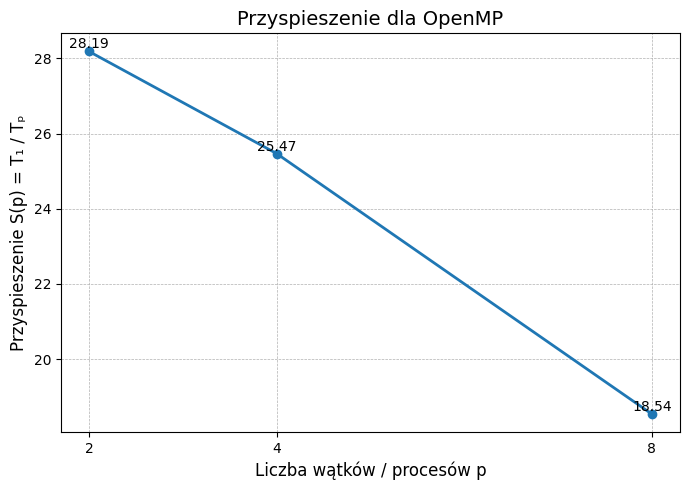

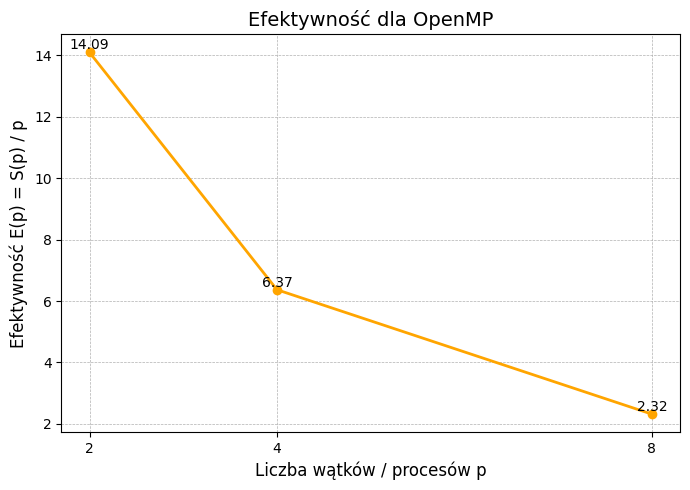

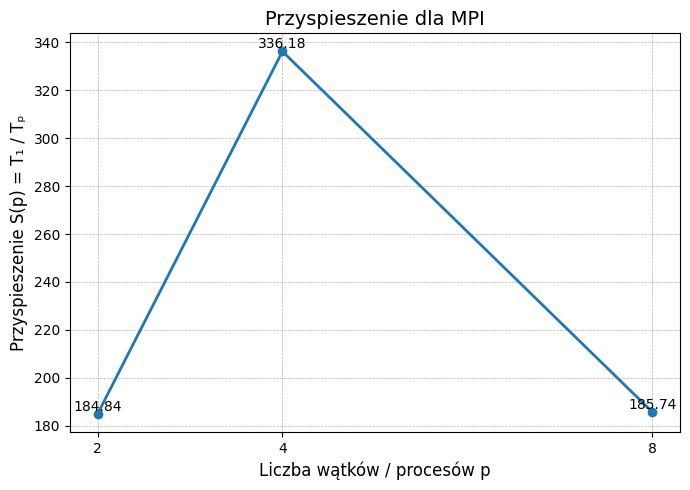

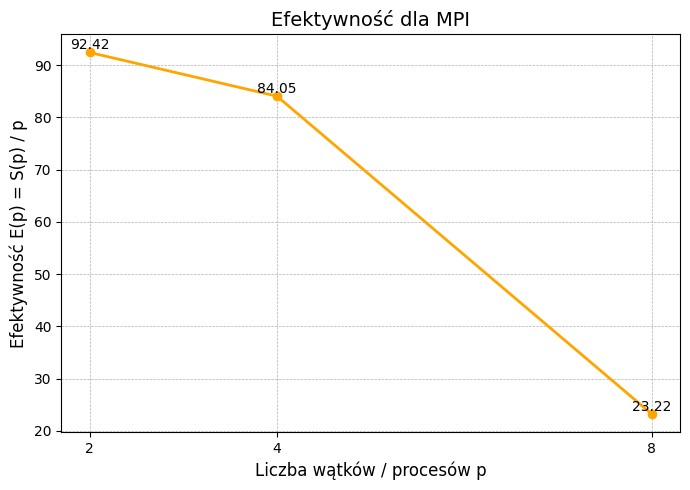

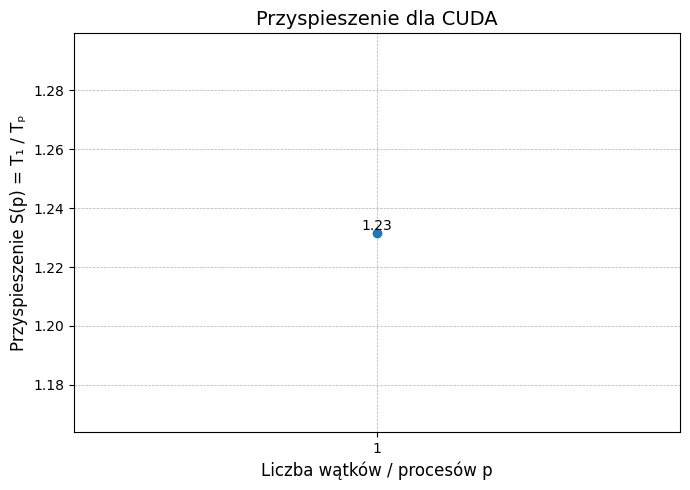

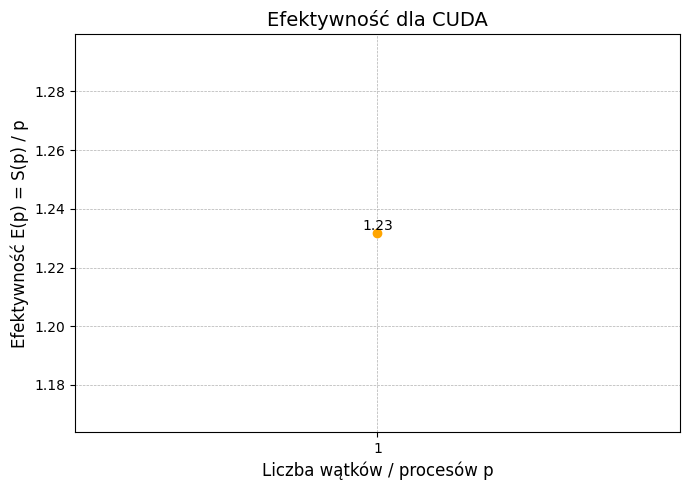

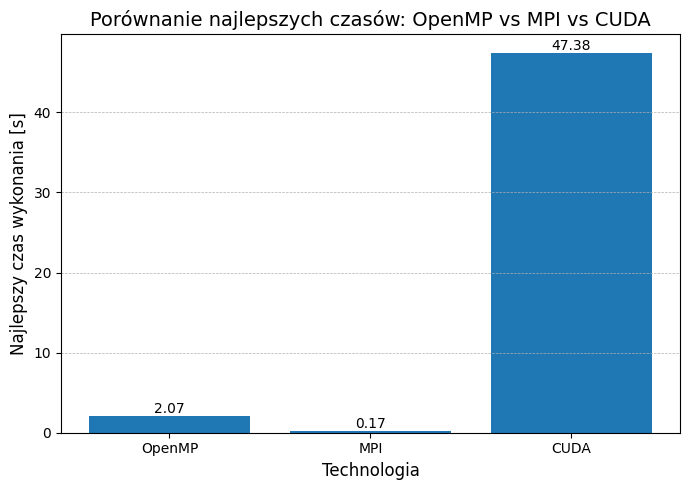

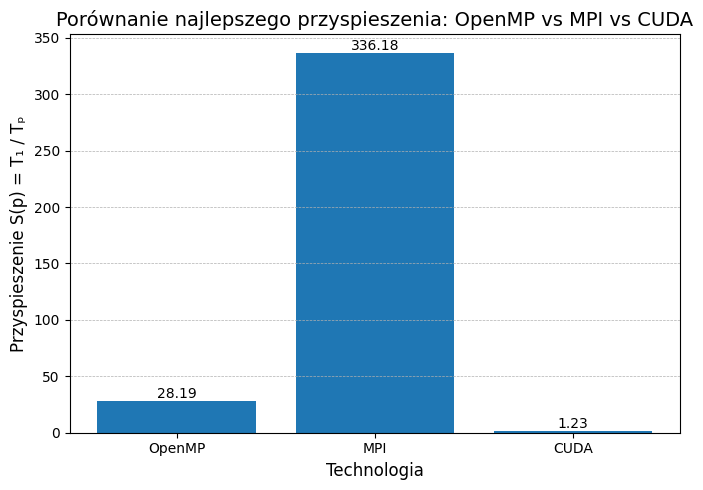

In [1]:
import json
import matplotlib.pyplot as plt

# ===== 1. Funkcje pomocnicze =====

def load_run(path):
    """Wczytaj pojedynczy plik JSON z wynikami."""
    with open(path, "r") as f:
        return json.load(f)

def prepare_backend_data(file_dict):
    """
    Zamienia słownik {p: filename} na listę:
    [(p, wall_time_seconds, filename), ...] posortowaną po p.
    """
    data = []
    for p, fname in sorted(file_dict.items(), key=lambda x: x[0]):
        run = load_run(fname)
        wall_time = run["wall_time_seconds"]
        data.append((p, wall_time, fname))
    return data

def add_point_labels(xs, ys):
    """Dodaje etykiety wartości nad punktami na wykresie."""
    for x, y in zip(xs, ys):
        plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=10)

def add_bar_labels(values):
    """Dodaje etykiety wartości nad słupkami."""
    for idx, v in enumerate(values):
        plt.text(idx, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)


def plot_speedup_and_efficiency(backend_name, data, T_seq):
    """
    Rysuje dwa wykresy dla danego backendu:
    - przyspieszenie S(p) = T_seq / T_p
    - efektywność E(p) = S(p) / p
    """
    ps = [p for p, _, _ in data]
    times = [wall for _, wall, _ in data]

    speedup = [T_seq / t for t in times]
    efficiency = [s / p for s, p in zip(speedup, ps)]

    # --- Wykres przyspieszenia ---
    plt.figure(figsize=(7, 5))
    plt.plot(ps, speedup, marker="o", linewidth=2)
    add_point_labels(ps, speedup)
    plt.xlabel("Liczba wątków / procesów p", fontsize=12)
    plt.ylabel("Przyspieszenie S(p) = T₁ / Tₚ", fontsize=12)
    plt.title(f"Przyspieszenie dla {backend_name}", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(ps)
    plt.tight_layout()
    plt.show()

    # --- Wykres efektywności ---
    plt.figure(figsize=(7, 5))
    plt.plot(ps, efficiency, marker="o", linewidth=2, color="orange")
    add_point_labels(ps, efficiency)
    plt.xlabel("Liczba wątków / procesów p", fontsize=12)
    plt.ylabel("Efektywność E(p) = S(p) / p", fontsize=12)
    plt.title(f"Efektywność dla {backend_name}", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(ps)
    plt.tight_layout()
    plt.show()


def plot_best_wall_times(openmp_data, mpi_data, cuda_data, T_seq):
    """
    Porównanie najlepszych czasów wykonania i przyspieszeń
    dla OpenMP, MPI i CUDA (po jednym najlepszym punkcie).
    """
    backends = []
    best_times = []
    best_speedups = []

    for name, data in [
        ("OpenMP", openmp_data),
        ("MPI", mpi_data),
        ("CUDA", cuda_data),
    ]:
        if not data:
            continue
        min_time = min(t for _, t, _ in data)
        backends.append(name)
        best_times.append(min_time)
        best_speedups.append(T_seq / min_time)

    # --- Wykres czasów ---
    plt.figure(figsize=(7, 5))
    bars = plt.bar(backends, best_times)
    add_bar_labels(best_times)
    plt.xlabel("Technologia", fontsize=12)
    plt.ylabel("Najlepszy czas wykonania [s]", fontsize=12)
    plt.title("Porównanie najlepszych czasów: OpenMP vs MPI vs CUDA", fontsize=14)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- Wykres przyspieszenia ---
    plt.figure(figsize=(7, 5))
    bars = plt.bar(backends, best_speedups)
    add_bar_labels(best_speedups)
    plt.xlabel("Technologia", fontsize=12)
    plt.ylabel("Przyspieszenie S(p) = T₁ / Tₚ", fontsize=12)
    plt.title("Porównanie najlepszego przyspieszenia: OpenMP vs MPI vs CUDA", fontsize=14)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


# ===== 2. Wczytanie danych =====

seq_run = load_run("cuda_default_test_run.json")
T_SEQ = seq_run["wall_time_seconds"]
print("Czas wersji sekwencyjnej T1:", T_SEQ, "s")

openmp_files = {
    2: "openmp_2_threads.json",
    4: "openmp_4_threads.json",
    8: "openmp_8_threads.json",
}
mpi_files = {
    2: "mpi_2_processes.json",
    4: "mpi_4_prpcesses.json",
    8: "mpi_8_processes.json",
}
cuda_files = {
    1: "cuda_20251208_192020.json",
}

openmp_data = prepare_backend_data(openmp_files)
mpi_data = prepare_backend_data(mpi_files)
cuda_data = prepare_backend_data(cuda_files)

# ===== 3. Rysowanie wykresów =====

plot_speedup_and_efficiency("OpenMP", openmp_data, T_SEQ)
plot_speedup_and_efficiency("MPI", mpi_data, T_SEQ)
plot_speedup_and_efficiency("CUDA", cuda_data, T_SEQ)

# ===== 4. Porównanie końcowe =====

plot_best_wall_times(openmp_data, mpi_data, cuda_data, T_SEQ)
